# Notebook 3: Clustering (KMeans y DBSCAN)

## Contexto del proyecto

Este notebook corresponde al **tercer paso** del Proyecto Final de Aprendizaje No Supervisado aplicado a una base histórica de créditos bancarios.

En los notebooks anteriores se realizó:

- **Notebook 1:** Limpieza, tratamiento de nulos y outliers, ingeniería de variables de riesgo y generación del dataset numérico estandarizado `data_processed.csv`.
- **Notebook 2:** Reducción de dimensionalidad mediante **PCA** y **UMAP**, obteniendo:
  - Componentes principales de PCA (explicando ~83% de la varianza con 10 componentes).
  - Un embedding 2D de UMAP que revela claramente la estructura de grupos en la cartera.

En este notebook utilizaremos estas representaciones reducidas (especialmente PCA) para aplicar **algoritmos de clustering** y evaluar formalmente la calidad de los segmentos.

---

## Objetivo del notebook

El objetivo principal es **identificar segmentos de clientes** dentro de la cartera de crédito, usando métodos de clustering no supervisado y métricas internas de evaluación. En particular:

1. Aplicar **KMeans** para diferentes valores de k y seleccionar un número razonable de clusters.
2. Aplicar **DBSCAN**, un método basado en densidad, capaz de detectar grupos de formas arbitrarias y puntos de ruido.
3. Evaluar y comparar los resultados de ambos algoritmos con métricas internas:
   - **Silhouette score**
   - **Índice de Davies-Bouldin**
   - **Índice de Calinski-Harabasz**
4. Visualizar los clusters sobre el **embedding 2D de UMAP**, para interpretar mejor la separación entre grupos.

---

## Pasos que se realizan en este notebook

1. **Carga de datos**
   - Lectura del dataset procesado `data_processed.csv`.
   - Lectura de la proyección de PCA seleccionada para clustering (por ejemplo, las primeras 10 componentes).
   - Revisión de dimensiones y estructura de la matriz de features `X_pca_clust`.

2. **Clustering con KMeans**
   - Entrenamiento de KMeans para distintos valores de k (por ejemplo, k = 2 a 10).
   - Cálculo de las métricas internas para cada k:
     - Silhouette
     - Davies-Bouldin
     - Calinski-Harabasz
   - Visualización de **curvas Silhouette vs k, Davies-Bouldin vs k y Calinski-Harabasz vs k** para apoyar la elección del k óptimo.
   - Selección de uno o dos modelos finales (por ejemplo, k=2 y k=5) y almacenamiento de las etiquetas de cluster.

3. **Clustering con DBSCAN**
   - Exploración de distintas combinaciones de `eps` y `min_samples`.
   - Cálculo de las mismas métricas internas para los casos válidos.
   - Análisis del número de clusters encontrados y proporción de puntos marcados como ruido.
   - Selección de un conjunto de hiperparámetros final (eps, min_samples) y generación de etiquetas de cluster DBSCAN.

4. **Unión de resultados y visualización sobre UMAP**
   - Unión de las etiquetas de KMeans y DBSCAN al dataset procesado.
   - Carga del embedding 2D de UMAP (`embedding_umap_2d.csv`).
   - Gráficos de dispersión UMAP coloreados por:
     - Clusters KMeans (k=5)
     - Clusters DBSCAN (clusters densos y ruido)
   - Comparación cualitativa de ambas segmentaciones.

5. **Perfilamiento preliminar de clusters**
   - Cálculo de medias por cluster para variables clave de riesgo (mora, saldos, límites, calificación).
   - Identificación de grupos de bajo riesgo, riesgo intermedio y alto riesgo.

---

## Resultado esperado

Al finalizar este notebook tendremos:

- **Etiquetas de cluster** para cada crédito, generadas por KMeans (k seleccionado) y por DBSCAN.
- **Métricas internas** que justifican la elección de los hiperparámetros de clustering.
- **Visualizaciones 2D** sobre el espacio UMAP que muestran claramente los grupos identificados.
- Una primera caracterización cuantitativa de cada cluster, que se profundizará en el:

> **Notebook 4 – Interpretación de resultados y conclusiones**, donde se traduce la segmentación en insights de negocio y recomendaciones para la gestión de la cartera de crédito.


In [1]:
# Notebook 3 - Clustering (KMeans y DBSCAN)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sns.set()
plt.rcParams["figure.figsize"] = (8, 6)

# 1) Cargar los datos procesados (mismo folder del notebook)
df = pd.read_csv("data_processed.csv")
print("Shape de data_processed:", df.shape)
df.head()


Shape de data_processed: (26559, 37)


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,...,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,-0.926575,-0.231648,0.352592,-0.800538,0.742507,0.039433,-0.857646,-0.015963,1.176483,-1.41293,...,1,0,0,0,0,0,0,0,0,0
1,-0.926575,1.001185,2.650131,-0.800538,-0.277841,-0.925580,0.007203,-0.536759,-0.849991,-1.41293,...,0,0,1,0,0,0,0,0,0,0
2,-0.926575,1.660012,2.734648,-0.800538,0.496868,-0.836523,-0.044986,-0.015963,1.176483,-1.41293,...,0,1,0,0,0,0,0,0,0,0
3,-0.926575,0.127563,0.322652,-0.800538,-0.844700,0.256891,-1.729950,0.178179,-0.849991,-1.41293,...,0,1,0,0,0,0,0,0,0,0
4,-0.926575,1.007400,3.311013,-0.800538,0.874774,1.692866,-1.394448,-0.015963,1.176483,-1.41293,...,1,0,0,1,0,0,0,0,0,0


In [2]:
# 2.1 - Matriz de features y PCA para clustering

print("=== PREPARACIÓN DE FEATURES PARA CLUSTERING ===")

# Usamos todas las columnas de df como features (ya están escaladas y numéricas)
X = df.values
print("Shape de X:", X.shape)

# Reducimos la dimensionalidad con PCA a 10 componentes
n_components_pca_clust = 10

pca_clust = PCA(n_components=n_components_pca_clust, random_state=42)
X_pca_clust = pca_clust.fit_transform(X)

print("Shape de X_pca_clust:", X_pca_clust.shape)

# Varianza explicada acumulada por estos 10 componentes
var_exp = pca_clust.explained_variance_ratio_.sum()
print(f"Varianza explicada acumulada por {n_components_pca_clust} componentes: {var_exp:.3f}")


=== PREPARACIÓN DE FEATURES PARA CLUSTERING ===
Shape de X: (26559, 37)
Shape de X_pca_clust: (26559, 10)
Varianza explicada acumulada por 10 componentes: 0.834


In [3]:
# 3.1 - KMeans para varios k y métricas de evaluación

print("=== KMEANS: BÚSQUEDA DE NÚMERO DE CLUSTERS ===")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

results_kmeans = []

# Probamos distintos valores de k
k_values = range(2, 11)  # k = 2,3,...,10

for k in k_values:
    print(f"\nEntrenando KMeans con k = {k} ...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca_clust)
    
    sil = silhouette_score(X_pca_clust, labels)
    db  = davies_bouldin_score(X_pca_clust, labels)
    ch  = calinski_harabasz_score(X_pca_clust, labels)
    
    results_kmeans.append({
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })
    
    print(f"  - Silhouette:        {sil:.3f}")
    print(f"  - Davies-Bouldin:    {db:.3f}")
    print(f"  - Calinski-Harabasz: {ch:.1f}")

results_kmeans_df = pd.DataFrame(results_kmeans)
results_kmeans_df


=== KMEANS: BÚSQUEDA DE NÚMERO DE CLUSTERS ===

Entrenando KMeans con k = 2 ...
  - Silhouette:        0.237
  - Davies-Bouldin:    1.706
  - Calinski-Harabasz: 8632.0

Entrenando KMeans con k = 3 ...
  - Silhouette:        0.210
  - Davies-Bouldin:    1.757
  - Calinski-Harabasz: 6681.7

Entrenando KMeans con k = 4 ...
  - Silhouette:        0.174
  - Davies-Bouldin:    1.896
  - Calinski-Harabasz: 5561.2

Entrenando KMeans con k = 5 ...
  - Silhouette:        0.146
  - Davies-Bouldin:    2.029
  - Calinski-Harabasz: 4943.5

Entrenando KMeans con k = 6 ...
  - Silhouette:        0.154
  - Davies-Bouldin:    1.949
  - Calinski-Harabasz: 4454.7

Entrenando KMeans con k = 7 ...
  - Silhouette:        0.160
  - Davies-Bouldin:    1.954
  - Calinski-Harabasz: 4160.0

Entrenando KMeans con k = 8 ...
  - Silhouette:        0.160
  - Davies-Bouldin:    1.912
  - Calinski-Harabasz: 3890.5

Entrenando KMeans con k = 9 ...
  - Silhouette:        0.162
  - Davies-Bouldin:    1.834
  - Calinski-Ha

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.236621,1.705878,8632.024176
1,3,0.209800,1.756665,6681.656772
2,4,0.173585,1.895586,5561.212192
3,5,0.145665,2.028507,4943.514151
4,6,0.153879,1.948873,4454.671231
5,7,0.160026,1.954469,4160.022835
6,8,0.159699,1.912253,3890.488034
7,9,0.162384,1.833901,3607.971829
8,10,0.150492,1.807915,3413.448420


=== MÉTRICAS DE EVALUACIÓN KMEANS VS k ===


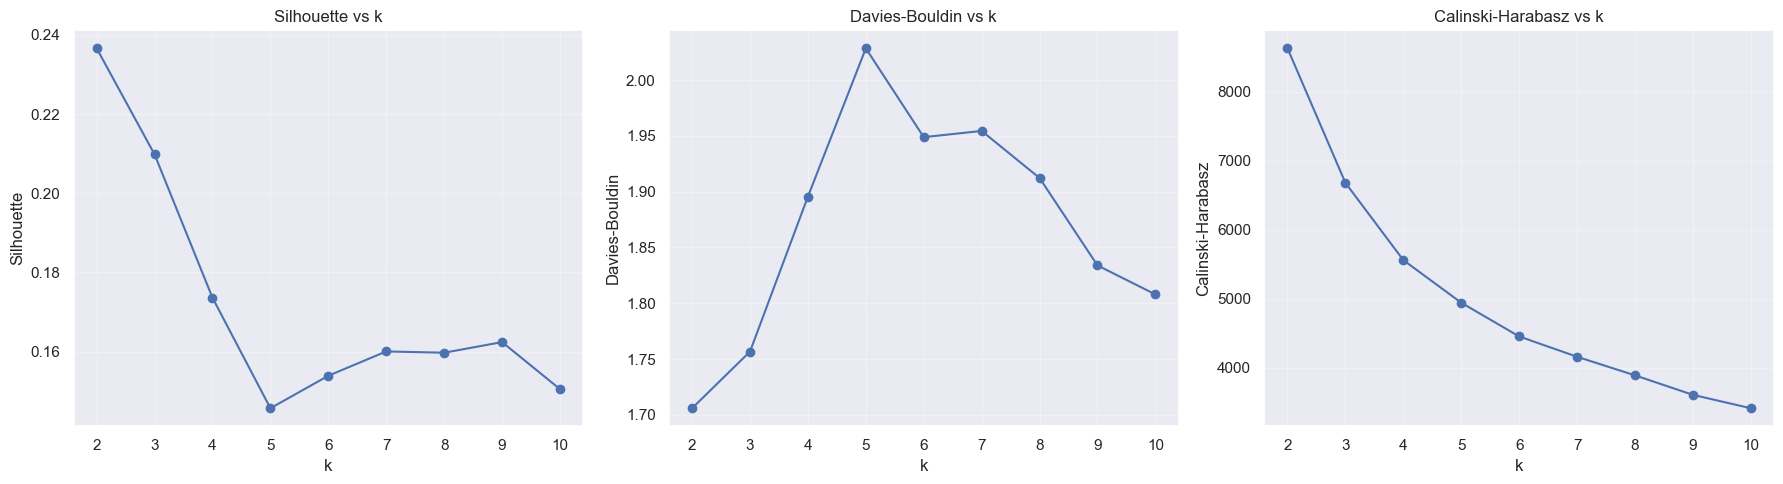

In [4]:
# 3.2 - Gráficos de métricas KMeans vs k

print("=== MÉTRICAS DE EVALUACIÓN KMEANS VS k ===")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette
axes[0].plot(results_kmeans_df["k"], results_kmeans_df["silhouette"], marker="o")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette")
axes[0].set_title("Silhouette vs k")
axes[0].grid(alpha=0.3)

# Davies-Bouldin
axes[1].plot(results_kmeans_df["k"], results_kmeans_df["davies_bouldin"], marker="o")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Davies-Bouldin")
axes[1].set_title("Davies-Bouldin vs k")
axes[1].grid(alpha=0.3)

# Calinski-Harabasz
axes[2].plot(results_kmeans_df["k"], results_kmeans_df["calinski_harabasz"], marker="o")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Calinski-Harabasz")
axes[2].set_title("Calinski-Harabasz vs k")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# 3.3 - Modelos finales de KMeans (k=2 y k=8)

print("=== MODELOS FINALES KMEANS ===")

# KMeans con k=2
k2 = 2
kmeans_2 = KMeans(n_clusters=k2, random_state=42, n_init=10)
labels_k2 = kmeans_2.fit_predict(X_pca_clust)

sil_k2 = silhouette_score(X_pca_clust, labels_k2)
db_k2  = davies_bouldin_score(X_pca_clust, labels_k2)
ch_k2  = calinski_harabasz_score(X_pca_clust, labels_k2)

print(f"\nKMeans k={k2}")
print(f"  - Silhouette:        {sil_k2:.3f}")
print(f"  - Davies-Bouldin:    {db_k2:.3f}")
print(f"  - Calinski-Harabasz: {ch_k2:.1f}")

# KMeans con k=8
k8 = 8
kmeans_8 = KMeans(n_clusters=k8, random_state=42, n_init=10)
labels_k8 = kmeans_8.fit_predict(X_pca_clust)

sil_k8 = silhouette_score(X_pca_clust, labels_k8)
db_k8  = davies_bouldin_score(X_pca_clust, labels_k8)
ch_k8  = calinski_harabasz_score(X_pca_clust, labels_k8)

print(f"\nKMeans k={k8}")
print(f"  - Silhouette:        {sil_k8:.3f}")
print(f"  - Davies-Bouldin:    {db_k8:.3f}")
print(f"  - Calinski-Harabasz: {ch_k8:.1f}")

# Añadir etiquetas al DataFrame original (df)
df_clusters = df.copy()
df_clusters["cluster_k2"] = labels_k2
df_clusters["cluster_k8"] = labels_k8

df_clusters.head()


=== MODELOS FINALES KMEANS ===

KMeans k=2
  - Silhouette:        0.237
  - Davies-Bouldin:    1.706
  - Calinski-Harabasz: 8632.0

KMeans k=8
  - Silhouette:        0.160
  - Davies-Bouldin:    1.912
  - Calinski-Harabasz: 3890.5


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,...,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E,cluster_k2,cluster_k8
0,-0.926575,-0.231648,0.352592,-0.800538,0.742507,0.039433,-0.857646,-0.015963,1.176483,-1.41293,...,0,0,0,0,0,0,0,0,0,3
1,-0.926575,1.001185,2.650131,-0.800538,-0.277841,-0.925580,0.007203,-0.536759,-0.849991,-1.41293,...,1,0,0,0,0,0,0,0,0,0
2,-0.926575,1.660012,2.734648,-0.800538,0.496868,-0.836523,-0.044986,-0.015963,1.176483,-1.41293,...,0,0,0,0,0,0,0,0,0,0
3,-0.926575,0.127563,0.322652,-0.800538,-0.844700,0.256891,-1.729950,0.178179,-0.849991,-1.41293,...,0,0,0,0,0,0,0,0,0,6
4,-0.926575,1.007400,3.311013,-0.800538,0.874774,1.692866,-1.394448,-0.015963,1.176483,-1.41293,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# 4.1 - DBSCAN: búsqueda de parámetros y métricas

from sklearn.cluster import DBSCAN

print("=== DBSCAN: BÚSQUEDA DE PARÁMETROS ===")

eps_values = [0.5, 0.8, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 20]

results_dbscan = []

for eps in eps_values:
    for min_s in min_samples_values:
        print(f"\nProbando DBSCAN con eps={eps}, min_samples={min_s} ...")
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        labels = dbscan.fit_predict(X_pca_clust)

        # Número de clusters (excluyendo ruido)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        print(f"  - Clusters encontrados (sin contar ruido): {n_clusters}")
        print(f"  - Puntos marcados como ruido: {n_noise}")

        if n_clusters >= 2:
            sil = silhouette_score(X_pca_clust, labels)
            db  = davies_bouldin_score(X_pca_clust, labels)
            ch  = calinski_harabasz_score(X_pca_clust, labels)

            print(f"  - Silhouette:        {sil:.3f}")
            print(f"  - Davies-Bouldin:    {db:.3f}")
            print(f"  - Calinski-Harabasz: {ch:.1f}")
        else:
            sil = np.nan
            db  = np.nan
            ch  = np.nan
            print("  - Métricas no calculadas (menos de 2 clusters).")

        results_dbscan.append({
            "eps": eps,
            "min_samples": min_s,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil,
            "davies_bouldin": db,
            "calinski_harabasz": ch
        })

results_dbscan_df = pd.DataFrame(results_dbscan)
results_dbscan_df


=== DBSCAN: BÚSQUEDA DE PARÁMETROS ===

Probando DBSCAN con eps=0.5, min_samples=5 ...
  - Clusters encontrados (sin contar ruido): 521
  - Puntos marcados como ruido: 22104
  - Silhouette:        -0.463
  - Davies-Bouldin:    1.155
  - Calinski-Harabasz: 9.4

Probando DBSCAN con eps=0.5, min_samples=10 ...
  - Clusters encontrados (sin contar ruido): 14
  - Puntos marcados como ruido: 26353
  - Silhouette:        -0.243
  - Davies-Bouldin:    1.180
  - Calinski-Harabasz: 13.1

Probando DBSCAN con eps=0.5, min_samples=20 ...
  - Clusters encontrados (sin contar ruido): 0
  - Puntos marcados como ruido: 26559
  - Métricas no calculadas (menos de 2 clusters).

Probando DBSCAN con eps=0.8, min_samples=5 ...
  - Clusters encontrados (sin contar ruido): 671
  - Puntos marcados como ruido: 9272
  - Silhouette:        -0.284
  - Davies-Bouldin:    1.316
  - Calinski-Harabasz: 36.2

Probando DBSCAN con eps=0.8, min_samples=10 ...
  - Clusters encontrados (sin contar ruido): 170
  - Puntos marc

,eps,min_samples,n_clusters,n_noise,silhouette,davies_bouldin,calinski_harabasz
0,0.5,5,521,22104,-0.463430,1.154524,9.399444
1,0.5,10,14,26353,-0.242969,1.179525,13.141225
2,0.5,20,0,26559,NaN,NaN,NaN
3,0.8,5,671,9272,-0.284344,1.315839,36.219358
4,0.8,10,170,17930,-0.390324,1.275070,48.467448
5,0.8,20,24,24206,-0.342750,1.363554,74.268056
6,1.0,5,273,3348,-0.284123,1.400487,84.066544
7,1.0,10,112,8407,-0.273356,1.505156,154.170099
8,1.0,20,50,16506,-0.319265,1.584351,159.732954
9,1.5,5,6,78,0.122339,2.364570,2632.370168


In [7]:
# 4.2 - Modelo final DBSCAN

print("=== MODELO FINAL DBSCAN (eps=1.5, min_samples=10) ===")

eps_final = 1.5
min_samples_final = 10

dbscan_final = DBSCAN(eps=eps_final, min_samples=min_samples_final)
labels_db = dbscan_final.fit_predict(X_pca_clust)

# Resumen de clusters
unique_labels, counts = np.unique(labels_db, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))

print("Clusters encontrados (incluye -1 como ruido):")
for label, cnt in cluster_counts.items():
    print(f"  Cluster {label}: {cnt} observaciones")

# Número de clusters reales (excluyendo ruido)
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_db = np.sum(labels_db == -1)

print(f"\nClusters (sin ruido): {n_clusters_db}")
print(f"Puntos de ruido:      {n_noise_db}")

# Métricas (solo si hay al menos 2 clusters válidos)
if n_clusters_db >= 2:
    sil_db = silhouette_score(X_pca_clust, labels_db)
    db_db  = davies_bouldin_score(X_pca_clust, labels_db)
    ch_db  = calinski_harabasz_score(X_pca_clust, labels_db)

    print(f"\nMétricas DBSCAN final:")
    print(f"  - Silhouette:        {sil_db:.3f}")
    print(f"  - Davies-Bouldin:    {db_db:.3f}")
    print(f"  - Calinski-Harabasz: {ch_db:.1f}")

# Añadir etiquetas DBSCAN al dataframe de clusters
df_clusters["cluster_dbscan"] = labels_db
df_clusters["is_noise_dbscan"] = (labels_db == -1).astype(int)

df_clusters.head()


=== MODELO FINAL DBSCAN (eps=1.5, min_samples=10) ===
Clusters encontrados (incluye -1 como ruido):
  Cluster -1: 279 observaciones
  Cluster 0: 3818 observaciones
  Cluster 1: 5040 observaciones
  Cluster 2: 7312 observaciones
  Cluster 3: 1700 observaciones
  Cluster 4: 8410 observaciones

Clusters (sin ruido): 5
Puntos de ruido:      279

Métricas DBSCAN final:
  - Silhouette:        0.132
  - Davies-Bouldin:    2.514
  - Calinski-Harabasz: 3186.6


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,...,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E,cluster_k2,cluster_k8,cluster_dbscan,is_noise_dbscan
0,-0.926575,-0.231648,0.352592,-0.800538,0.742507,0.039433,-0.857646,-0.015963,1.176483,-1.41293,...,0,0,0,0,0,0,0,3,0,0
1,-0.926575,1.001185,2.650131,-0.800538,-0.277841,-0.925580,0.007203,-0.536759,-0.849991,-1.41293,...,0,0,0,0,0,0,0,0,1,0
2,-0.926575,1.660012,2.734648,-0.800538,0.496868,-0.836523,-0.044986,-0.015963,1.176483,-1.41293,...,0,0,0,0,0,0,0,0,0,0
3,-0.926575,0.127563,0.322652,-0.800538,-0.844700,0.256891,-1.729950,0.178179,-0.849991,-1.41293,...,0,0,0,0,0,0,0,6,1,0
4,-0.926575,1.007400,3.311013,-0.800538,0.874774,1.692866,-1.394448,-0.015963,1.176483,-1.41293,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# 5.1 - Cargar embedding UMAP 2D y unir con clusters

print("=== PREPARANDO DATOS PARA VISUALIZAR CLUSTERS EN UMAP 2D ===")

# Cargar el embedding UMAP 2D que guardamos en Notebook 2
umap_2d_df = pd.read_csv("embedding_umap_2d.csv")
print("Shape de umap_2d_df:", umap_2d_df.shape)

# Verificamos que tenga el mismo número de filas que df_clusters
print("Shape de df_clusters:", df_clusters.shape)

# Unir coordenadas UMAP con etiquetas de clusters
plot_df = pd.concat(
    [umap_2d_df.reset_index(drop=True),
     df_clusters[["cluster_k2", "cluster_k8", "cluster_dbscan", "is_noise_dbscan"]].reset_index(drop=True)],
    axis=1
)

plot_df.head()


=== PREPARANDO DATOS PARA VISUALIZAR CLUSTERS EN UMAP 2D ===
Shape de umap_2d_df: (26559, 2)
Shape de df_clusters: (26559, 41)


,UMAP1,UMAP2,cluster_k2,cluster_k8,cluster_dbscan,is_noise_dbscan
0,12.732705,2.369354,0,3,0,0
1,-0.335836,-5.849336,0,0,1,0
2,13.015741,4.789525,0,0,0,0
3,0.457837,-3.360731,0,6,1,0
4,13.428514,4.754014,0,0,0,0


=== UMAP 2D + KMeans (k=8) ===


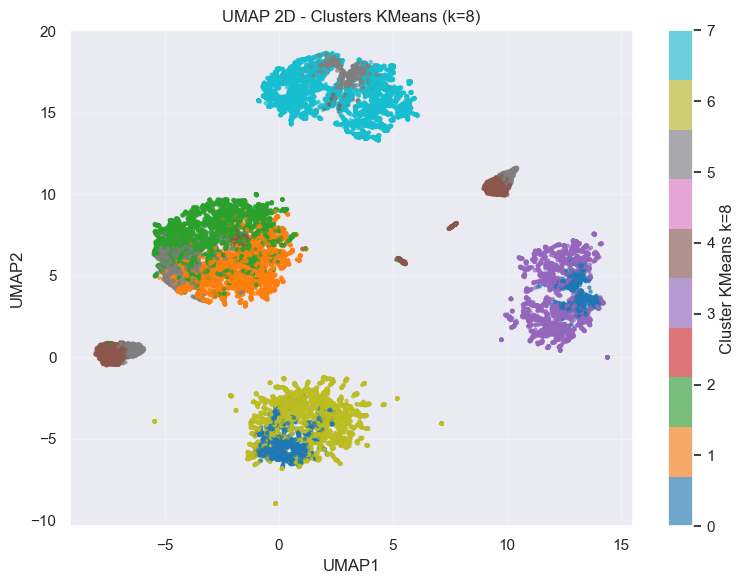

In [9]:
# 5.2 - UMAP 2D coloreado por clusters KMeans (k=8)

print("=== UMAP 2D + KMeans (k=8) ===")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    plot_df["UMAP1"],
    plot_df["UMAP2"],
    c=plot_df["cluster_k8"],
    s=5,
    alpha=0.6,
    cmap="tab10"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP 2D - Clusters KMeans (k=8)")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Cluster KMeans k=8")
plt.tight_layout()
plt.show()



In [10]:
# 5.A - KMeans con k=5

print("=== MODELO KMEANS k=5 ===")

k5 = 5
kmeans_5 = KMeans(n_clusters=k5, random_state=42, n_init=10)
labels_k5 = kmeans_5.fit_predict(X_pca_clust)

sil_k5 = silhouette_score(X_pca_clust, labels_k5)
db_k5  = davies_bouldin_score(X_pca_clust, labels_k5)
ch_k5  = calinski_harabasz_score(X_pca_clust, labels_k5)

print(f"KMeans k={k5}")
print(f"  - Silhouette:        {sil_k5:.3f}")
print(f"  - Davies-Bouldin:    {db_k5:.3f}")
print(f"  - Calinski-Harabasz: {ch_k5:.1f}")

# Guardar en df_clusters
df_clusters["cluster_k5"] = labels_k5

df_clusters[["cluster_k2", "cluster_k5", "cluster_k8", "cluster_dbscan"]].head()


=== MODELO KMEANS k=5 ===
KMeans k=5
  - Silhouette:        0.146
  - Davies-Bouldin:    2.029
  - Calinski-Harabasz: 4943.5


,cluster_k2,cluster_k5,cluster_k8,cluster_dbscan
0,0,1,3,0
1,0,1,0,1
2,0,1,0,0
3,0,1,6,1
4,0,1,0,0


=== UMAP 2D + KMeans (k=5) ===


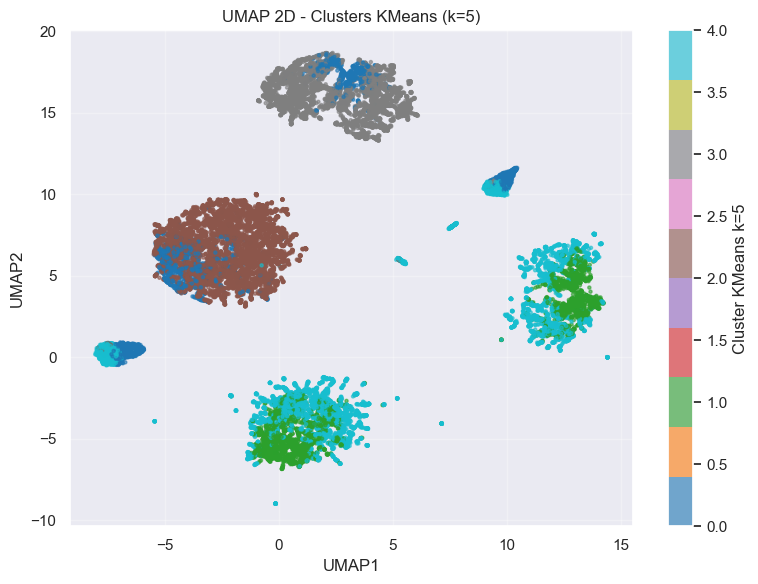

In [11]:
# 5.B - UMAP 2D coloreado por clusters KMeans (k=5)

print("=== UMAP 2D + KMeans (k=5) ===")

plot_df_k5 = pd.concat(
    [umap_2d_df.reset_index(drop=True),
     df_clusters[["cluster_k5"]].reset_index(drop=True)],
    axis=1
)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    plot_df_k5["UMAP1"],
    plot_df_k5["UMAP2"],
    c=plot_df_k5["cluster_k5"],
    s=5,
    alpha=0.6,
    cmap="tab10"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP 2D - Clusters KMeans (k=5)")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Cluster KMeans k=5")
plt.tight_layout()
plt.show()


In [12]:
# 6.1 - Perfiles de clusters KMeans k=5 (medias por variable clave)

print("=== PERFILES DE CLUSTERS KMEANS (k=5) ===")

# Elegimos algunas variables clave para interpretar los clusters
features_clave = [
    "Numero Dias Mora",
    "Valor Limite",
    "Valor Saldo Total",
    "Valor Mora Total",
    "Valor Cuota",
    "edad",
    "antiguedad_meses",
    "meses_a_vencimiento",
    "ratio_mora",
    "ratio_saldo_limite",
    "mora_30",
    "Calificacion_A2",
    "Calificacion_B",
    "Calificacion_C1",
    "Calificacion_C2",
    "Calificacion_D1",
    "Calificacion_D2",
    "Calificacion_E",
]

# Nos aseguramos de quedarnos solo con las columnas que existen
features_clave = [c for c in features_clave if c in df_clusters.columns]

print("Variables utilizadas para el perfilado:")
print(features_clave)

# Tamaño de cada cluster
print("\nTamaño de cada cluster (k=5):")
print(df_clusters["cluster_k5"].value_counts().sort_index())

# Perfiles promedio
cluster_profiles_k5 = df_clusters.groupby("cluster_k5")[features_clave].mean()
cluster_profiles_k5


=== PERFILES DE CLUSTERS KMEANS (k=5) ===
Variables utilizadas para el perfilado:
['Numero Dias Mora', 'Valor Limite', 'Valor Saldo Total', 'Valor Mora Total', 'Valor Cuota', 'edad', 'antiguedad_meses', 'meses_a_vencimiento', 'ratio_mora', 'ratio_saldo_limite', 'mora_30', 'Calificacion_A2', 'Calificacion_B', 'Calificacion_C1', 'Calificacion_C2', 'Calificacion_D1', 'Calificacion_D2', 'Calificacion_E']

Tamaño de cada cluster (k=5):
cluster_k5
0    3658
1    4150
2    7132
3    5009
4    6610
Name: count, dtype: int64


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
cluster_k5,,,,,,,,,,,,,,,,,,
0,-0.145503,0.757070,1.158083,1.981645,0.004995,0.033641,-0.239783,0.123033,0.695149,0.709616,0.224829,0.000000,0.341443,0.133953,0.076818,0.414981,0.012302,0.020503
1,-0.926575,0.447642,1.314577,-0.800538,0.024698,0.022792,-0.751606,0.233259,-1.412930,1.224389,-1.098050,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.858006,-0.195940,-0.502883,0.010744,0.043793,0.039480,0.594434,-0.251992,0.710470,-0.468367,0.905072,0.000280,0.001683,0.058188,0.057487,0.524958,0.093102,0.264162
3,0.819281,-0.151836,-0.475097,0.044332,-0.068872,-0.009140,0.490059,-0.015963,0.710470,-0.454924,0.904289,0.000200,0.002396,0.066480,0.063486,0.521461,0.089639,0.256339
4,-0.884348,-0.373538,-0.563606,-0.639230,-0.013332,-0.068599,-0.408157,0.069453,-0.802573,-0.311328,-1.096834,0.021785,0.224357,0.000605,0.000000,0.000000,0.000000,0.031467


=== UMAP 2D + DBSCAN ===


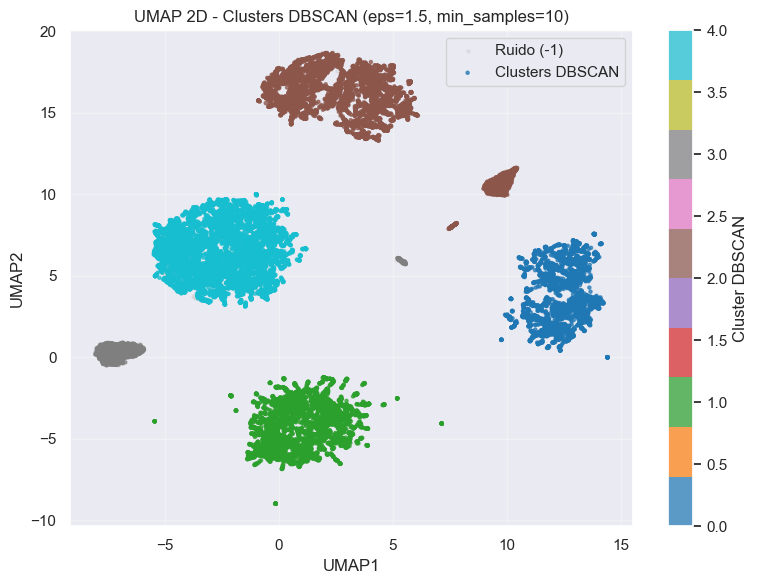

In [13]:
# 5.C - UMAP 2D coloreado por clusters DBSCAN (marcando ruido)

print("=== UMAP 2D + DBSCAN ===")

plot_df_db = plot_df.copy()  # ya tiene UMAP1, UMAP2, cluster_dbscan, is_noise_dbscan

# Separar ruido y puntos asignados a clusters
mask_noise = plot_df_db["cluster_dbscan"] == -1
mask_cluster = ~mask_noise

plt.figure(figsize=(8, 6))

# Ruido en gris claro
plt.scatter(
    plot_df_db.loc[mask_noise, "UMAP1"],
    plot_df_db.loc[mask_noise, "UMAP2"],
    c="lightgray",
    s=5,
    alpha=0.5,
    label="Ruido (-1)"
)

# Puntos asignados a clusters, coloreados por etiqueta DBSCAN
scatter = plt.scatter(
    plot_df_db.loc[mask_cluster, "UMAP1"],
    plot_df_db.loc[mask_cluster, "UMAP2"],
    c=plot_df_db.loc[mask_cluster, "cluster_dbscan"],
    s=5,
    alpha=0.7,
    cmap="tab10",
    label="Clusters DBSCAN"
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP 2D - Clusters DBSCAN (eps=1.5, min_samples=10)")
plt.grid(alpha=0.3)
cbar = plt.colorbar(scatter, label="Cluster DBSCAN")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [14]:
# 6.2 - Perfiles de clusters DBSCAN (sin incluir ruido -1)

print("=== PERFILES DE CLUSTERS DBSCAN ===")

features_clave = [
    "Numero Dias Mora",
    "Valor Limite",
    "Valor Saldo Total",
    "Valor Mora Total",
    "Valor Cuota",
    "edad",
    "antiguedad_meses",
    "meses_a_vencimiento",
    "ratio_mora",
    "ratio_saldo_limite",
    "mora_30",
    "Calificacion_A2",
    "Calificacion_B",
    "Calificacion_C1",
    "Calificacion_C2",
    "Calificacion_D1",
    "Calificacion_D2",
    "Calificacion_E",
]

# Asegurar que todas existan
features_clave = [c for c in features_clave if c in df_clusters.columns]

print("Variables usadas para el perfilado:")
print(features_clave)

# Tamaño de cada cluster (incluye ruido)
print("\nTamaño de cada cluster DBSCAN (incluye -1 como ruido):")
print(df_clusters["cluster_dbscan"].value_counts().sort_index())

# Perfiles promedio de clusters "reales" (excluimos ruido -1)
mask_real = df_clusters["cluster_dbscan"] != -1
cluster_profiles_db = df_clusters[mask_real].groupby("cluster_dbscan")[features_clave].mean()

cluster_profiles_db


=== PERFILES DE CLUSTERS DBSCAN ===
Variables usadas para el perfilado:
['Numero Dias Mora', 'Valor Limite', 'Valor Saldo Total', 'Valor Mora Total', 'Valor Cuota', 'edad', 'antiguedad_meses', 'meses_a_vencimiento', 'ratio_mora', 'ratio_saldo_limite', 'mora_30', 'Calificacion_A2', 'Calificacion_B', 'Calificacion_C1', 'Calificacion_C2', 'Calificacion_D1', 'Calificacion_D2', 'Calificacion_E']

Tamaño de cada cluster DBSCAN (incluye -1 como ruido):
cluster_dbscan
-1     279
 0    3818
 1    5040
 2    7312
 3    1700
 4    8410
Name: count, dtype: int64


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
cluster_dbscan,,,,,,,,,,,,,,,,,,
0,-0.926575,0.009282,0.357155,-0.800538,-0.087145,-0.063722,-0.592998,-0.015963,-1.412930,0.467049,-1.098050,0.108172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.926575,0.020498,0.339445,-0.800538,0.052033,-0.010863,-0.563163,0.258624,-1.412930,0.433739,-1.098050,0.106944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.440695,0.014179,-0.153180,0.425439,-0.051273,0.004615,0.242492,-0.015963,0.707153,-0.213106,0.537086,0.005607,0.160558,0.071663,0.057303,0.442560,0.063457,0.192560
3,-0.759054,-0.040146,-0.038524,0.555967,0.060108,-0.001402,-0.418090,0.202566,0.703714,-0.006955,-1.098050,0.033529,0.874118,0.000000,0.000000,0.000000,0.000000,0.061765
4,0.754994,-0.040472,-0.262435,0.299976,0.036709,0.029818,0.476520,-0.172510,0.709861,-0.309845,0.910705,0.000000,0.000000,0.078002,0.067063,0.545541,0.081688,0.227705


In [15]:
df_clusters.to_csv("data_with_clusters.csv", index=False)
